In [1]:
import os
from os import path
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math
import autolens as al

from PIL import Image

import numpy as np
import pandas as pd
from torchvision.io import read_image

In [2]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', columns=None, train=True, all=False, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if columns:
            if 'name' not in columns:
                columns.append('name')
            df = df[columns]
        if all:
            self.img_labels = df
        elif train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer, device = None):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

In [4]:
root = "__local/data/Cosmosim/12-short"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [5]:
training_data.img_labels

,name,r_ein,x_l,y_l,ellx_l,elly_l,x_s,y_s
0,jdhlfa.png,1.561475,0.450575,0.336202,0.038853,0.378490,0.209685,0.068804
1,50x0jy.png,0.882000,-0.327052,0.388154,0.111429,-0.194266,-0.587585,0.823733
2,4awboh.png,1.560557,-0.073504,0.012457,0.358193,0.107528,0.135327,1.308714
3,mqmz78.png,1.185200,0.025806,0.424926,0.106775,0.173785,-0.580237,1.327479
4,mfdb97.png,1.813213,0.487977,-0.249355,-0.143646,-0.137791,1.148418,-1.305975
...,...,...,...,...,...,...,...,...
47995,rldlum.png,1.610092,-0.495699,-0.079425,0.006301,-0.217894,-0.378240,0.638819
47996,tl3k7l.png,1.671884,-0.467254,-0.425288,0.154120,-0.207310,0.736440,-0.542272
47997,3vva83.png,1.690678,0.416090,-0.428181,-0.316118,-0.089685,0.141503,0.920210
47998,xqfuiv.png,1.639695,-0.183831,-0.352044,-0.143082,-0.364025,-1.242161,-0.072287


In [6]:
test_data.img_labels

,name,r_ein,x_l,y_l,ellx_l,elly_l,x_s,y_s
48000,3lhoc2.png,1.266827,-0.069803,-0.154302,0.284637,-0.035658,-0.874239,0.045066
48001,r0g10l.png,0.975060,-0.246361,-0.253246,-0.324981,-0.235421,-0.164524,0.300850
48002,bf1qx5.png,1.631005,0.343975,0.193979,-0.347722,0.132563,1.226082,-0.895492
48003,t7d0pp.png,1.259736,-0.412950,-0.427907,-0.375316,0.185907,-0.957808,-0.223827
48004,h1emus.png,1.900743,-0.126447,-0.023018,-0.257618,0.165262,1.414058,-0.208151
...,...,...,...,...,...,...,...,...
59995,z2mmgq.png,0.954868,-0.308977,0.053434,-0.399581,0.237499,-0.921215,0.330579
59996,0jt2a1.png,1.027352,-0.087865,0.450551,-0.065415,-0.158194,-0.411397,0.546104
59997,x44bxs.png,1.105849,0.341765,0.165831,0.311576,-0.067476,0.581124,-0.147638
59998,1epjwj.png,0.990908,-0.151471,0.072576,-0.236218,0.215202,0.118866,0.911799


In [7]:
training_data.classes

['r_ein', 'x_l', 'y_l', 'ellx_l', 'elly_l', 'x_s', 'y_s']

In [8]:
labels_map = training_data.img_labels.r_ein
labels_map

0        1.561475
1        0.882000
2        1.560557
3        1.185200
4        1.813213
           ...   
47995    1.610092
47996    1.671884
47997    1.690678
47998    1.639695
47999    1.483416
Name: r_ein, Length: 48000, dtype: float64

In [9]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([1.5615, 0.4506, 0.3362, 0.0389, 0.3785, 0.2097, 0.0688])


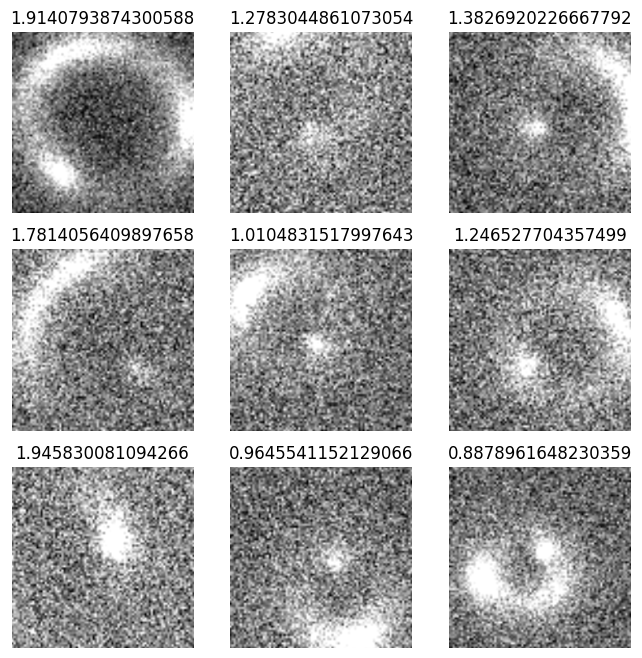

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 7])


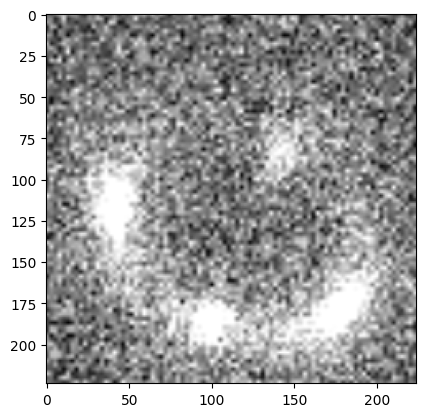

Label: tensor([ 1.6253, -0.1970,  0.2477,  0.3640, -0.3377, -0.4319,  0.0837])


In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [15]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.925657  [   64/48000]
loss: 0.179189  [ 6464/48000]
loss: 0.117092  [12864/48000]
loss: 0.078547  [19264/48000]
loss: 0.084297  [25664/48000]
loss: 0.061881  [32064/48000]
loss: 0.052252  [38464/48000]
loss: 0.042245  [44864/48000]
Test Error:
Avg loss: 0.028094 

Epoch 2
-------------------------------
loss: 0.056616  [   64/48000]
loss: 0.042673  [ 6464/48000]
loss: 0.048252  [12864/48000]
loss: 0.037271  [19264/48000]
loss: 0.027580  [25664/48000]
loss: 0.034589  [32064/48000]
loss: 0.029966  [38464/48000]
loss: 0.031674  [44864/48000]
Test Error:
Avg loss: 0.029491 

Epoch 3
-------------------------------
loss: 0.039441  [   64/48000]
loss: 0.023320  [ 6464/48000]
loss: 0.025988  [12864/48000]
loss: 0.022468  [19264/48000]
loss: 0.035150  [25664/48000]
loss: 0.025215  [32064/48000]
loss: 0.024868  [38464/48000]
loss: 0.026187  [44864/48000]
Test Error:
Avg loss: 0.019945 

Epoch 4
-------------------------------
loss: 0.022551  [   6

In [18]:
torch.save(model.state_dict(), '__local/models/model_alexnet_caustics_short.pth')

### Evaluation

In [17]:
root = "__local/data/Cosmosim/test_slacs_6"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

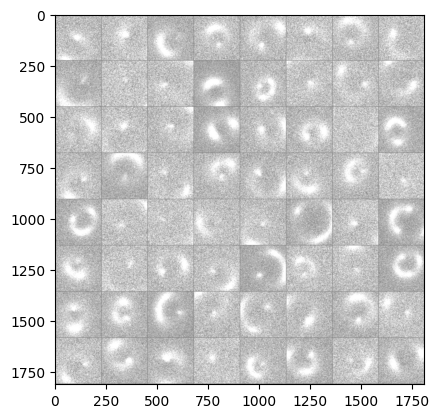

In [19]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [20]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, len(training_data.classes))

In [22]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
model_path = '__local/models/model_alexnet_caustics_short.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [24]:
def evaluate(dataloader, model, loss_fn, device = 'cpu'):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    preds = torch.empty((0,len(training_data.classes)))
    reals = torch.empty((0,len(training_data.classes)))
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            preds = torch.cat((preds, pred))
            reals = torch.cat((reals, y))

    return pd.DataFrame(preds), pd.DataFrame(reals)

In [25]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [27]:
pd.DataFrame({'pred': preds.iloc[5], 'real': reals.iloc[1]})

,pred,real
0,1.582288,1.602879
1,-0.057139,0.116818
2,0.302703,0.485172
3,0.318491,0.039433
4,-0.119147,-0.213759
5,-0.861931,-0.282863
6,-0.126841,1.740190


In [28]:
preds

,0,1,2,3,4,5,6
0,1.800349,0.031472,-0.132037,-0.104882,0.268097,0.829297,0.825119
1,1.628093,0.064984,0.433128,0.089789,-0.198945,-0.462973,1.429701
2,1.601293,0.164503,0.341471,-0.039640,0.055047,-0.649039,1.423322
3,1.673829,0.232732,-0.343109,-0.147340,0.043755,-0.433306,0.856562
4,1.528313,0.285887,-0.117720,0.150161,0.004911,1.142211,-0.958432
...,...,...,...,...,...,...,...
95,1.490880,-0.012124,-0.076235,0.330914,0.329343,-0.038756,-0.762375
96,1.638348,0.227006,0.053057,-0.015056,-0.306375,0.912125,0.772528
97,0.885987,0.052910,-0.082447,-0.184060,0.289573,0.353521,-0.207182
98,1.950524,-0.087940,0.050158,-0.301642,-0.312388,-0.063307,1.002927


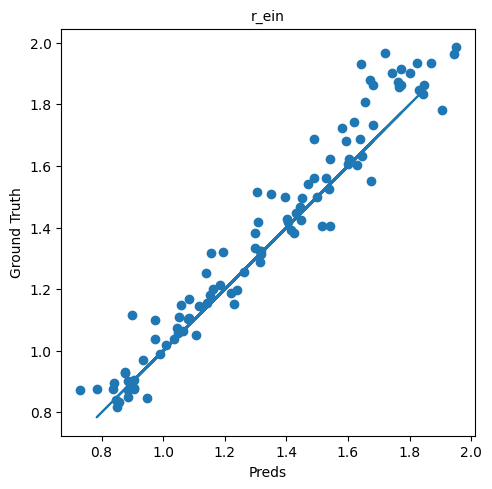

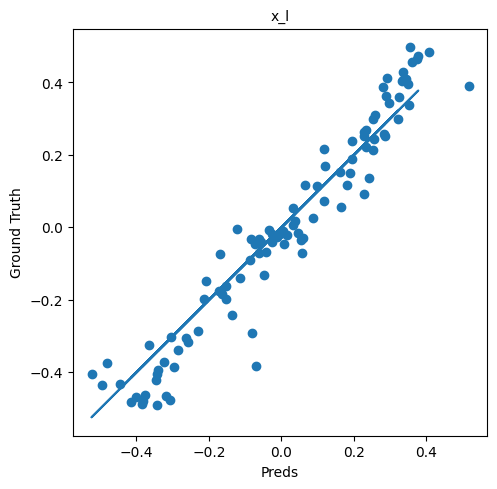

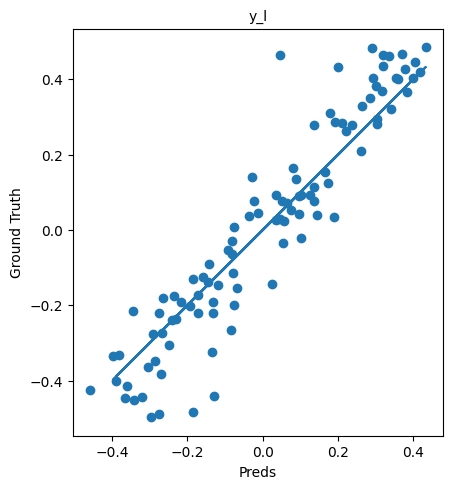

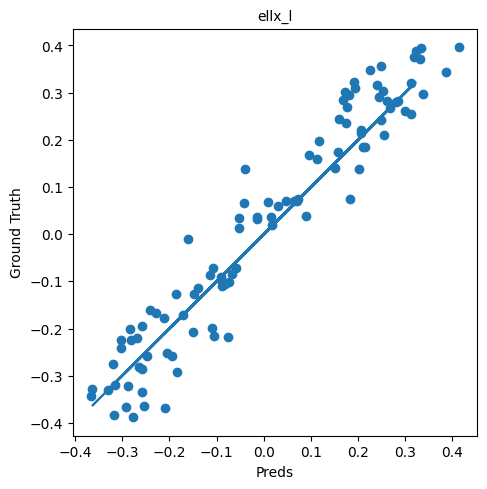

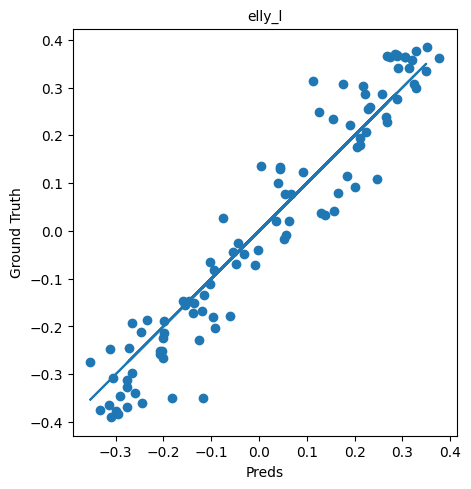

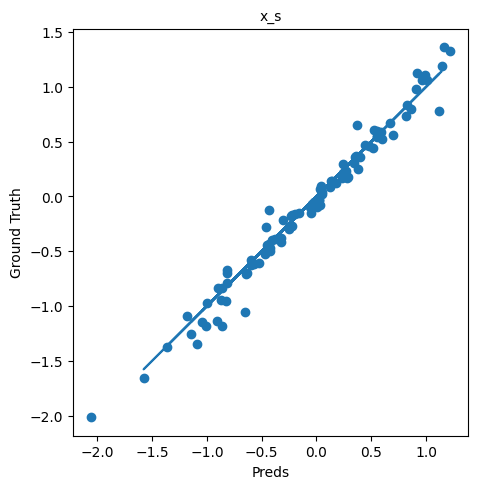

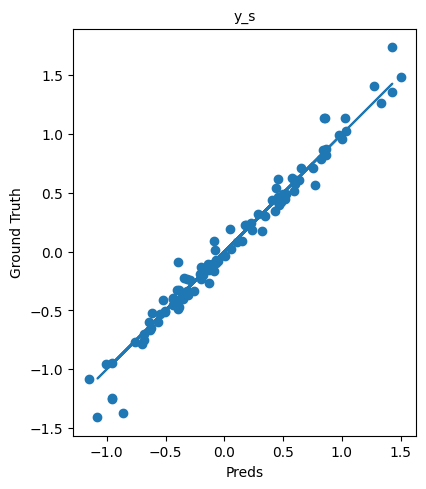

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time

date = time.strftime("%Y%m%d%H%M%S")
figs_path = '__local/reports/figures/{}'.format(date)

test_path = path.join(figs_path, 'test')
Path(test_path).mkdir(parents=True, exist_ok=True)

for i in range(7):
    fig, ax = plt.subplots()
    i=i
    x = preds[i][:32]
    y = reals[i][:32]
    a, b = np.polyfit(x, x, 1)
    
    ax.scatter(preds[i][:256], reals[i][:256])
    ax.plot(x, a*x+b)
    
    # ax.set_xlim(1.1, 1.7)
    # ax.set_ylim(1.1, 1.7)
    ax.set_aspect('equal', 'box')
    ax.set_title(training_data.classes[i], fontsize=10)
    
    fig.tight_layout()
    
    plt.xlabel("Preds")
    plt.ylabel("Ground Truth")
    plt.savefig(path.join(test_path, '{}.png'.format(training_data.classes[i])))

# plt.show()

In [30]:
root = "__local/data/Cosmosim/slacs/selected"
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    columns=['name','r_ein','x_l','y_l','ellx_l','elly_l','x_s','y_s'],
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

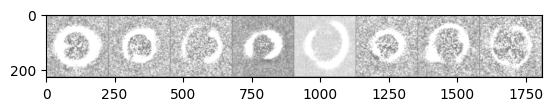

In [31]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [32]:
def simulate(grid, lens_galaxy, source_galaxy, simulator, shape=100):

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy, source_galaxy]
    )

    dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

    data = np.array(dataset.data)

    # Choose the lower and upper percentiles for normalization
    lower_percentile = 1
    upper_percentile = 95

    # Calculate the lower and upper limits for normalization
    lower_limit = np.percentile(data, lower_percentile)
    upper_limit = np.percentile(data, upper_percentile)

    # Clip and normalize the data to the 0-255 range
    normalized_data = np.clip(data, lower_limit, upper_limit)
    normalized_data = ((normalized_data - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)

    normalized_data = normalized_data.reshape(shape,shape)

    im = Image.fromarray(normalized_data).convert('L')
    # im = im.resize((400,400))

    return im

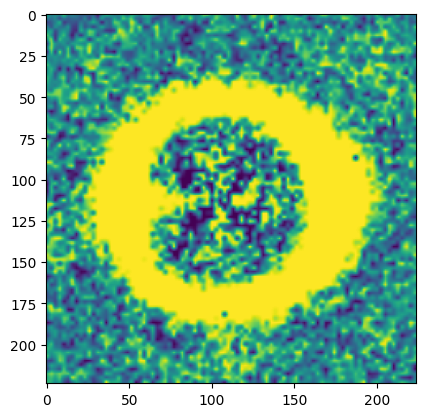

tensor([ 1.2675,  0.0096, -0.0918, -0.0348, -0.0353, -0.0071, -0.0330],
       grad_fn=<SelectBackward0>)
['r_ein', 'x_l', 'y_l', 'ellx_l', 'elly_l', 'x_s', 'y_s']


In [33]:
outputs = model(images)
i = 0
imshow(images[i])
print(outputs[i])
print(test_data.classes)

In [43]:
def model_paramaters(parameters):
    shape = 100
    scale = 0.05
    
    grid = al.Grid2D.uniform(
        shape_native=(shape, shape), 
        pixel_scales=scale
    )
    
    psf = al.Kernel2D.from_gaussian(
        shape_native=(21, 21), 
        sigma=0.1, 
        pixel_scales=grid.pixel_scales
    )
    
    simulator = al.SimulatorImaging(
        exposure_time=720.0, 
        psf=psf, 
        background_sky_level=0, 
        add_poisson_noise=True
    )
    
    lens = al.Galaxy(
        redshift=0.5,
        mass=al.mp.Isothermal(
            centre=(parameters.x_l, parameters.y_l), einstein_radius=parameters.r_ein, ell_comps=(parameters.ellx_l, parameters.elly_l)
        ),
    )
    
    source = al.Galaxy(
        redshift=1.0,
        bulge=al.lp.Sersic(
            centre=(parameters.x_s,parameters.y_s),
            ell_comps=(0,0),
            intensity=1,
            effective_radius=1,
            sersic_index=2,
        ),
    )

    return simulate(grid, lens, source, simulator, shape)

In [44]:
outputs = model(images)
outputs = outputs.detach().numpy()
parameters = pd.DataFrame(outputs, columns=training_data.classes)

In [45]:
parameters

,r_ein,x_l,y_l,ellx_l,elly_l,x_s,y_s
0,1.267450,0.009602,-0.091771,-0.034786,-0.035278,-0.007098,-0.033025
1,1.033125,-0.109573,0.088955,-0.150128,-0.105236,-0.021576,0.118302
2,1.436533,-0.028708,0.140776,-0.001282,-0.180311,0.034579,0.011692
3,1.279070,-0.244674,0.025306,-0.180382,-0.132059,-0.220641,-0.010244
4,1.887690,0.219524,-0.066054,-0.181237,0.099450,0.156064,0.055918
5,1.249958,-0.089347,-0.039523,0.054379,0.062724,-0.084022,0.086768
6,1.354996,0.046569,0.025635,-0.196212,-0.048821,0.124498,-0.081250
7,1.557566,0.040173,-0.103313,-0.103810,-0.104126,0.090451,-0.029222


In [46]:
output_images = []

reconstructed_path = path.join(figs_path, 'reconstructed')
Path(reconstructed_path).mkdir(parents=True, exist_ok=True)

for i in range(len(parameters.index)):
    im = model_paramaters(parameters.iloc[i])
    output_images.append(im)
    im.save(path.join(reconstructed_path, '{}.png'.format(i)))

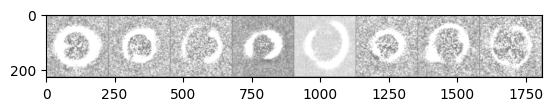

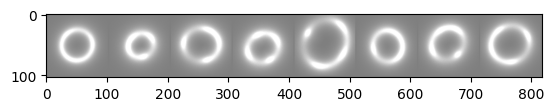

In [47]:
transform = transforms.Compose([transforms.ToTensor()])
out = [transform(x) for x in output_images]
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(out))

In [48]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [49]:
pd.DataFrame({'pred': preds.iloc[5], 'real': reals.iloc[1]})

,pred,real
0,1.436533,1.000000
1,-0.028708,0.000000
2,0.140776,0.000000
3,-0.001282,-0.059750
4,-0.180311,-0.188355
5,0.034579,0.000000
6,0.011692,0.000000


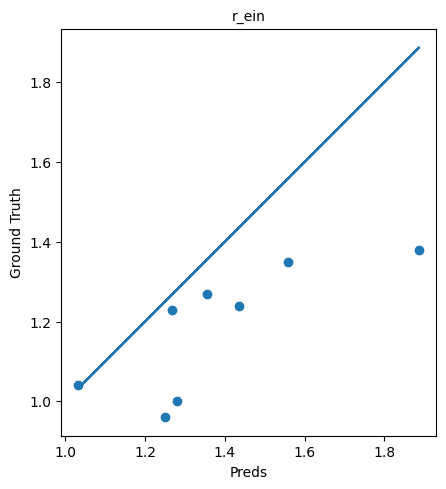

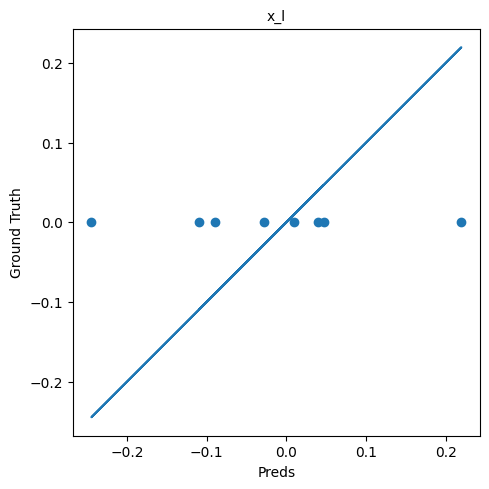

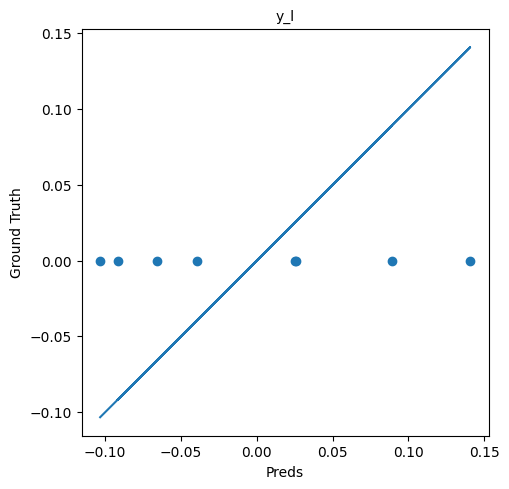

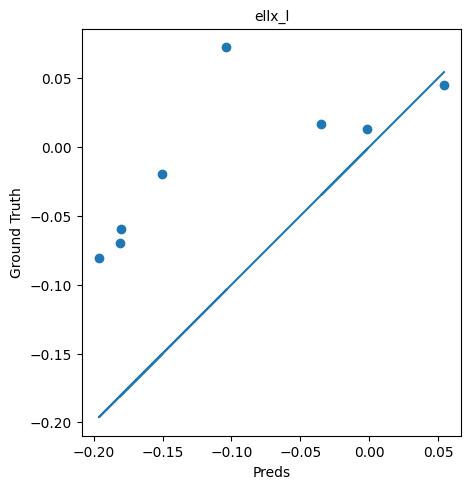

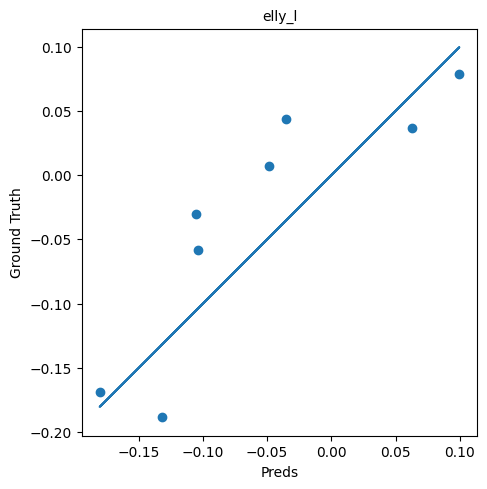

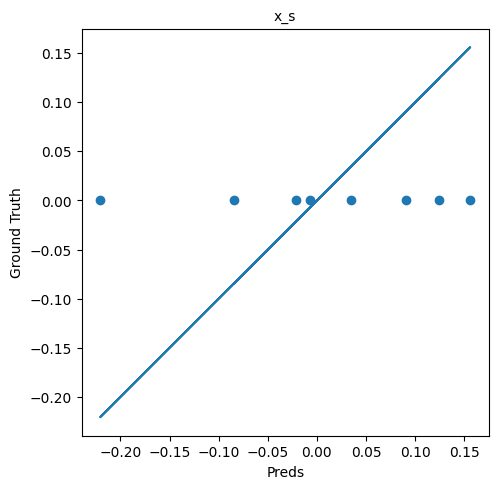

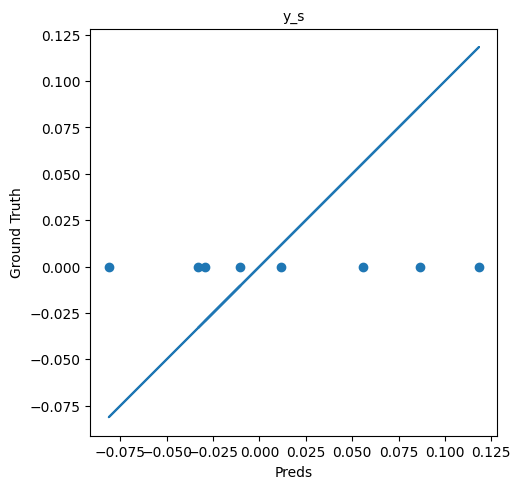

In [50]:
import matplotlib.pyplot as plt
import numpy as np

empirical_path = path.join(figs_path, 'empirical')
Path(empirical_path).mkdir(parents=True, exist_ok=True)

for i in range(7):
    fig, ax = plt.subplots()
    i=i
    x = preds[i][:8]
    y = reals[i][:8]
    a, b = np.polyfit(x, x, 1)
    
    ax.scatter(preds[i][:8], reals[i][:8])
    ax.plot(x, a*x+b)
    
    # ax.set_xlim(1.1, 1.7)
    # ax.set_ylim(1.1, 1.7)
    ax.set_aspect('equal', 'box')
    ax.set_title(training_data.classes[i], fontsize=10)
    
    fig.tight_layout()
    
    plt.xlabel("Preds")
    plt.ylabel("Ground Truth")
    plt.savefig(path.join(empirical_path, '{}.png'.format(training_data.classes[i])))